In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [30]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

In [6]:
print("TensorFlow v" + tf.__version__)
print("TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow v2.13.0
TensorFlow Decision Forests v1.5.0


In [7]:
train_file_path = "../input/house-prices-advanced-regression-techniques/train.csv"
dataset_df = pd.read_csv(train_file_path)
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (1460, 81)


In [8]:
dataset_df = dataset_df.drop('Id', axis=1)

In [9]:
dataset_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [10]:
dataset_df.Fence

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
        ...  
1455      NaN
1456    MnPrv
1457    GdPrv
1458      NaN
1459      NaN
Name: Fence, Length: 1460, dtype: object

count    1460.000000
mean     2007.815753
std         1.328095
min      2006.000000
25%      2007.000000
50%      2008.000000
75%      2009.000000
max      2010.000000
Name: YrSold, dtype: float64


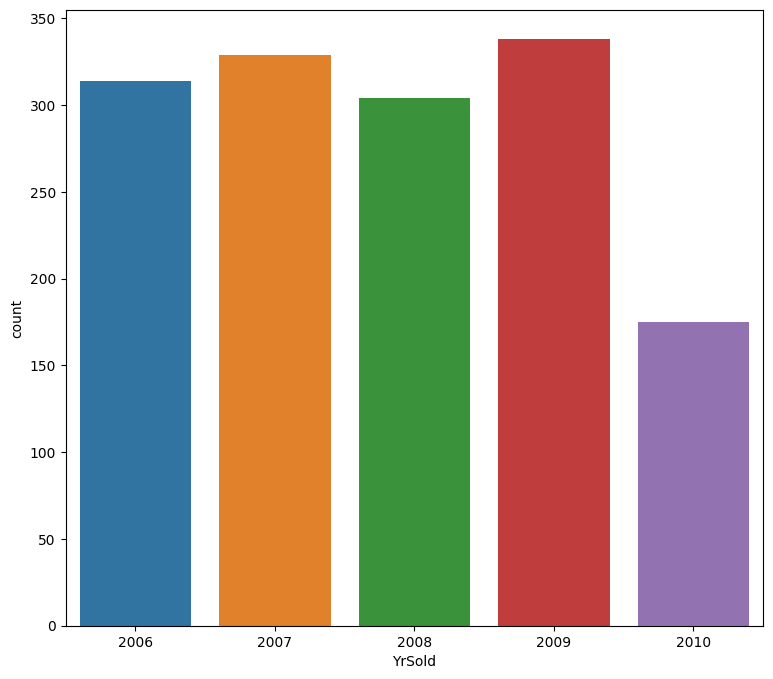

In [11]:
catagorical_feature = "YrSold"
print(dataset_df[catagorical_feature].describe())
plt.figure(figsize=(9, 8))
sns.countplot(x=catagorical_feature,data=dataset_df);

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


/tmp/ipykernel_42/3736081580.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset_df[feature], color='g', bins=100, hist_kws={'alpha': 0.4});


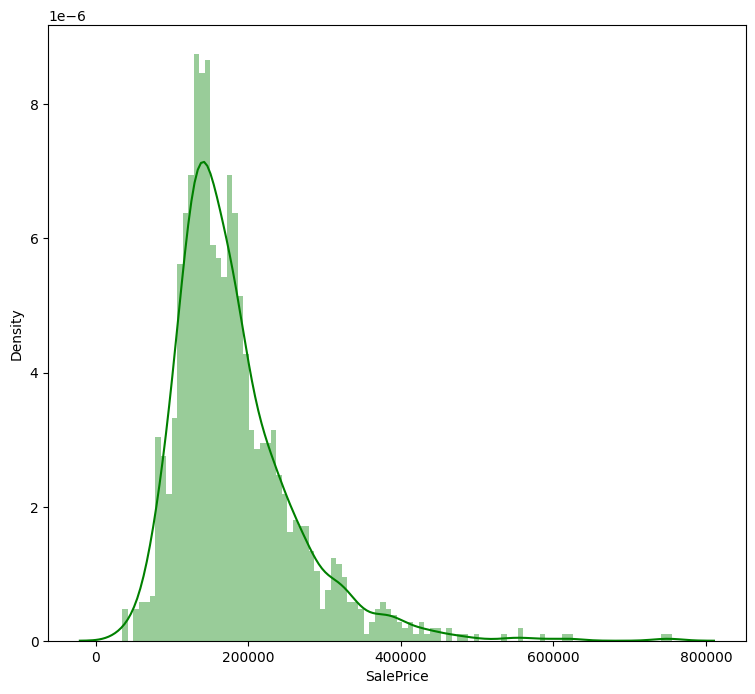

In [12]:
feature = "SalePrice"
print(dataset_df[feature].describe())
plt.figure(figsize=(9, 8))
sns.distplot(dataset_df[feature], color='g', bins=100, hist_kws={'alpha': 0.4});

#Check mean - median Sale price across years.
We can see non significant diffrence based on YrSold. We conclude that prices have dropped

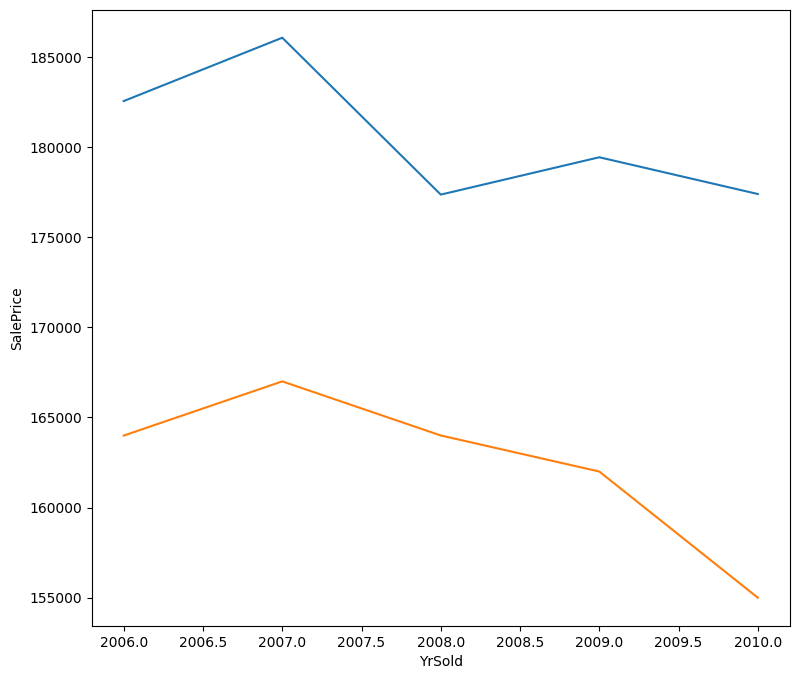

In [13]:
feature_X = "YrSold"
feature_Y = "SalePrice"
plt.figure(figsize=(9, 8))
sns.lineplot(data = dataset_df.groupby(feature_X)[feature_Y].mean().to_frame().head(), x=feature_X, y=feature_Y);
sns.lineplot(data = dataset_df.groupby(feature_X)[feature_Y].median().to_frame().head(), x=feature_X, y=feature_Y);

In [14]:
df_num = dataset_df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


In [15]:
df_num = dataset_df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


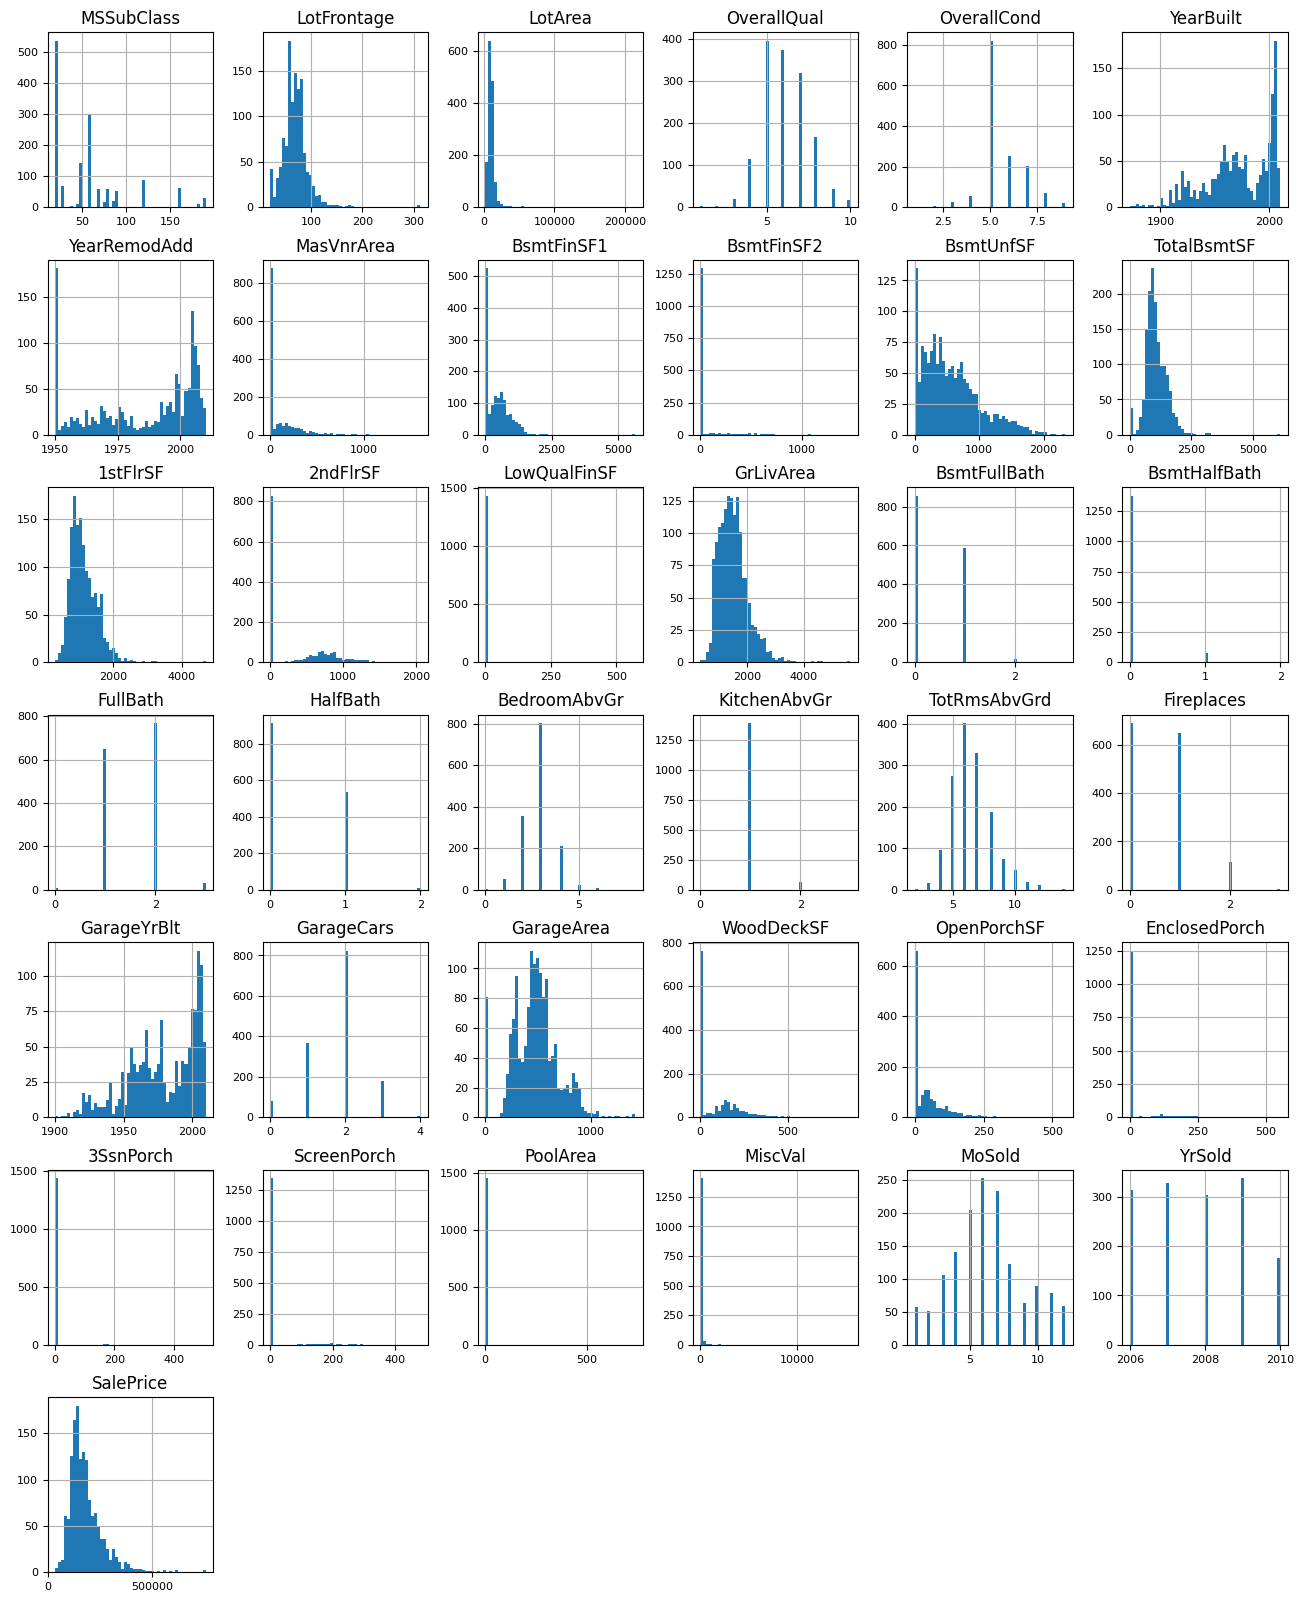

In [16]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

In [17]:
import numpy as np

def split_dataset(dataset, test_ratio=0.30):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

1022 examples in training, 438 examples in testing.


In [18]:
label = 'SalePrice'
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)

In [19]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [20]:
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
rf.compile(metrics=["mse"]) # Optional, you can use this to include a list of eval metrics

Use /tmp/tmpj6dy27ux as temporary training directory


In [21]:
rf.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:08.946353. Found 1022 examples.
Training model...


[INFO 23-12-24 17:58:45.3009 UTC kernel.cc:1243] Loading model from path /tmp/tmpj6dy27ux/model/ with prefix 88a413b95d0647e9


Model trained in 0:00:02.241382
Compiling model...


[INFO 23-12-24 17:58:45.7439 UTC decision_forest.cc:660] Model loaded with 300 root(s), 97160 node(s), and 75 input feature(s).
[INFO 23-12-24 17:58:45.7440 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-12-24 17:58:45.7441 UTC kernel.cc:1075] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


In [22]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=4)

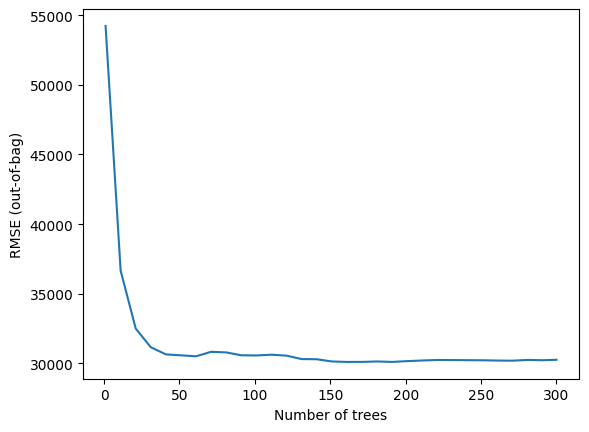

In [23]:
import matplotlib.pyplot as plt
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

In [24]:
logs[5]

TrainLog(num_trees=51, evaluation=Evaluation(num_examples=1022, accuracy=None, loss=None, rmse=30583.42873516327, ndcg=None, aucs=None, auuc=None, qini=None))

In [25]:
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=1022, accuracy=None, loss=None, rmse=30264.736919228464, ndcg=None, aucs=None, auuc=None, qini=None)

In [26]:
evaluation = rf.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 1s 861ms/step - loss: 0.0000e+00 - mse: 680680704.0000
loss: 0.0000
mse: 680680704.0000


In [27]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 NUM_AS_ROOT
	 INV_MEAN_MIN_DEPTH
	 SUM_SCORE
	 NUM_NODES


In [28]:
inspector.variable_importances()["NUM_AS_ROOT"]

[("OverallQual" (1; #62), 111.0),
 ("ExterQual" (4; #22), 65.0),
 ("GarageCars" (1; #32), 35.0),
 ("Neighborhood" (4; #59), 34.0),
 ("GrLivArea" (1; #38), 22.0),
 ("BsmtQual" (4; #14), 12.0),
 ("KitchenQual" (4; #44), 7.0),
 ("YearBuilt" (1; #76), 6.0),
 ("FullBath" (1; #29), 2.0),
 ("GarageYrBlt" (1; #37), 2.0),
 ("TotalBsmtSF" (1; #73), 2.0),
 ("1stFlrSF" (1; #0), 1.0),
 ("GarageArea" (1; #31), 1.0)]

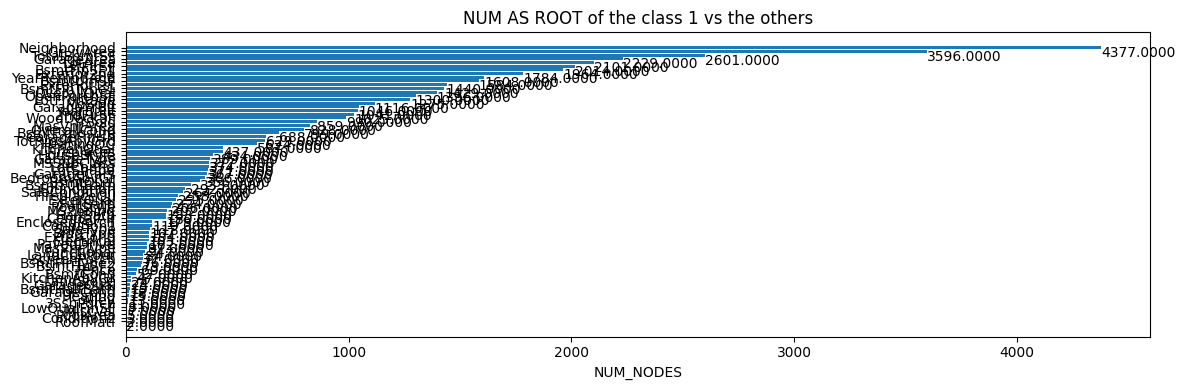

In [33]:


plt.figure(figsize=(12, 4))

# Mean decrease in AUC of the class 1 vs the others.
variable_importance_metric = "INV_MEAN_MIN_DEPTH"
variable_importances = inspector.variable_importances()[variable_importance_metric]

# Extract the feature name and importance values.
#
# `variable_importances` is a list of <feature, importance> tuples.
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# TODO: Replace with "plt.bar_label()" when available.
# Label each bar with values
for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title("NUM AS ROOT of the class 1 vs the others")
plt.tight_layout()
plt.show()

In [34]:
test_file_path = "../input/house-prices-advanced-regression-techniques/test.csv"
test_data = pd.read_csv(test_file_path)
ids = test_data.pop('Id')

test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    test_data,
    task = tfdf.keras.Task.REGRESSION)

preds = rf.predict(test_ds)
output = pd.DataFrame({'Id': ids,
                       'SalePrice': preds.squeeze()})

output.head()

2/2 [==============================] - 1s 25ms/step


,Id,SalePrice
0,1461,126469.882812
1,1462,148813.296875
2,1463,178014.375000
3,1464,185055.359375
4,1465,201796.625000


In [36]:
sample_submission_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv')
sample_submission_df['SalePrice'] = rf.predict(test_ds)
sample_submission_df.to_csv('/kaggle/working/submission.csv', index=False)
sample_submission_df.head()

2/2 [==============================] - 0s 27ms/step


,Id,SalePrice
0,1461,126469.882812
1,1462,148813.296875
2,1463,178014.375000
3,1464,185055.359375
4,1465,201796.625000
